# Quantum Volume

The quantum volume is a holistic quantum computer performance measure [QVOL0, QVOL1, QVOL2].


Roughly the logarithm (base 2) of quantum volume $V_Q$, quantifies the largest random circuit of equal width and depth that the computer successfully implements and is certifiably quantum.

So if you have 64 qubits and the best log-QV you have measured is $\log_2V_Q = 3$ then effectively you only have a 3 qubit device!



The quantum volume metric accounts for all relevant hardware parameters, e.g.

* coherence
* calibration errors
* crosstalk 
* spectator errors
* gate fidelity, measurement fidelity, initialization fidelity
* qubit connectivity 
* gate set

## Some details

A circuit that measures the quantum volume consists of layers of  a permutations of $n$ qubits followed by nearest neighbor two qubit Haar random unitaries. At the end we measure in the computational basis. See Figure 1.

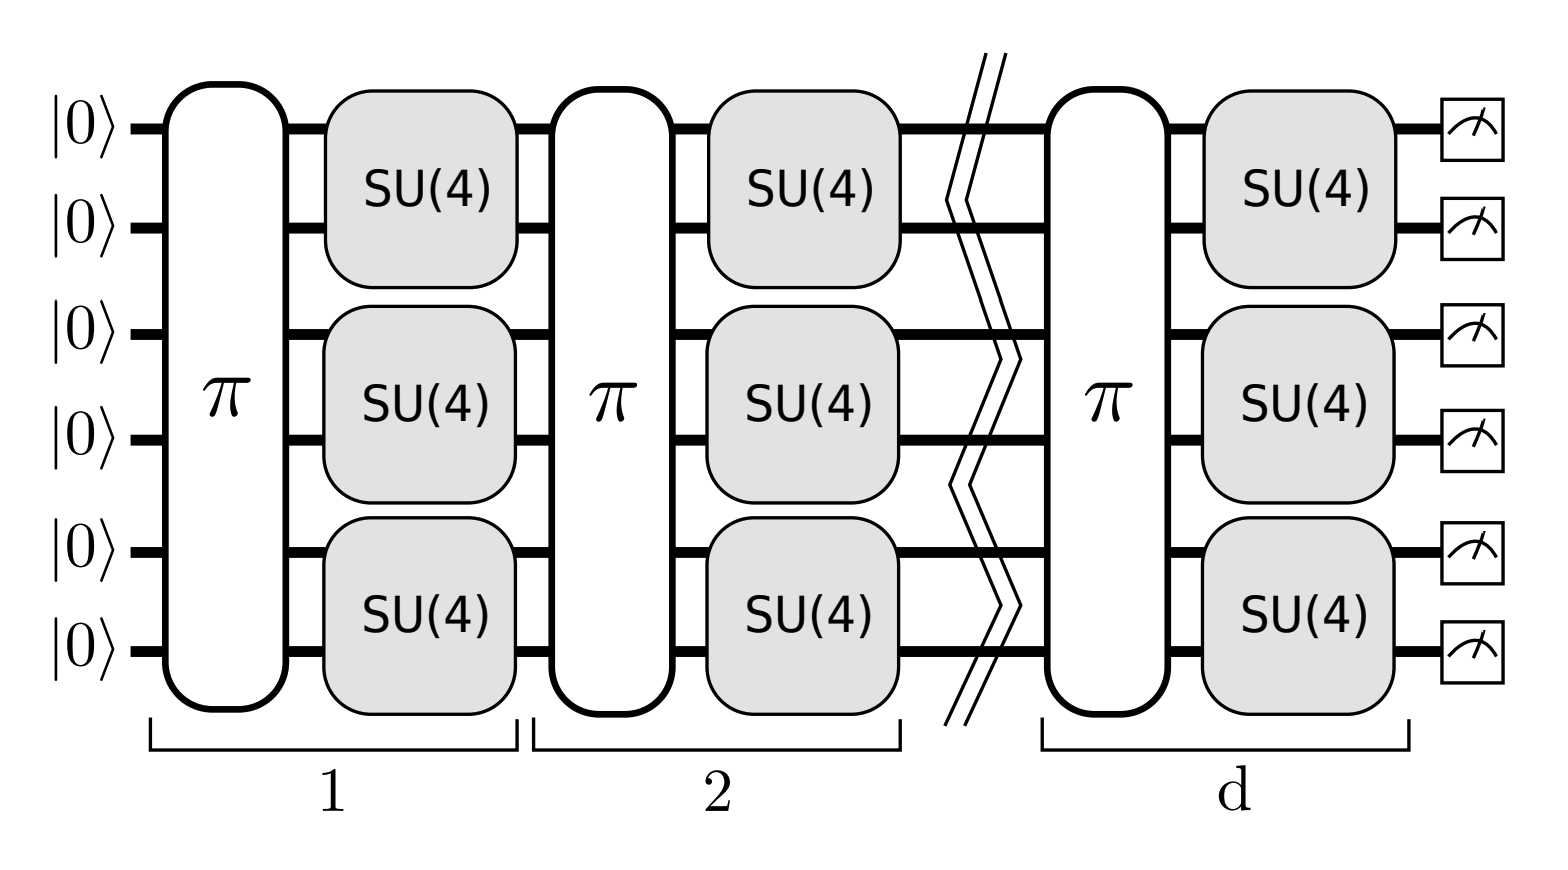
Figure 1. from [Cross et al.](https://arxiv.org/abs/1811.12926) [QVOL0].

A circuit to measure the quantum volume consists of a permutation gate on $n$ qubits denoted by $\pi$ in the above figure. The gate ${\rm SU}(4)$ denotes are two qubit gate drawn from the Haar measure on the [special unitary group](https://en.wikipedia.org/wiki/Special_unitary_group) of degree 4.
    
The certification of quantumness comes from the so called **Heavy Output Generation** problem and the **Quantum Threshold Assumption** see [HOG] for more details.

| [QVOL0] *Validating quantum computers using randomized model circuits.*  
|     Cross et al.  
|     arXiv:1811.12926 (2018).  
|     https://arxiv.org/abs/1811.12926  

| [QVOL1] *Quantum optimization using variational algorithms on near-term quantum devices.*  
|     Moll et al.  
|     Quantum Science and Technology 3, Number 3 2018.  
|     https://doi.org/10.1088/2058-9565/aab822  
|     https://arxiv.org/abs/1710.01022  

| [QVOL2] *Quantum Volume.*  
|     Bishop et al.  
|     (2017).  
|     https://ibm.co/2NdyRvf  

| [HOG] *Complexity-Theoretic Foundations of Quantum Supremacy Experiments.*  
|     Aaronson and Chen.  
|     32nd Computational Complexity Conference, vol 79 (CCC 2017).  
|     https://doi.org/10.4230/LIPIcs.CCC.2017.22  
|     https://arxiv.org/abs/1612.05903  

Some imports, get noisy and ideal QVM

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
show_progress_bar = True

from pyquil import get_qc

The qubits we will run on are [0, 1, 2, 3]


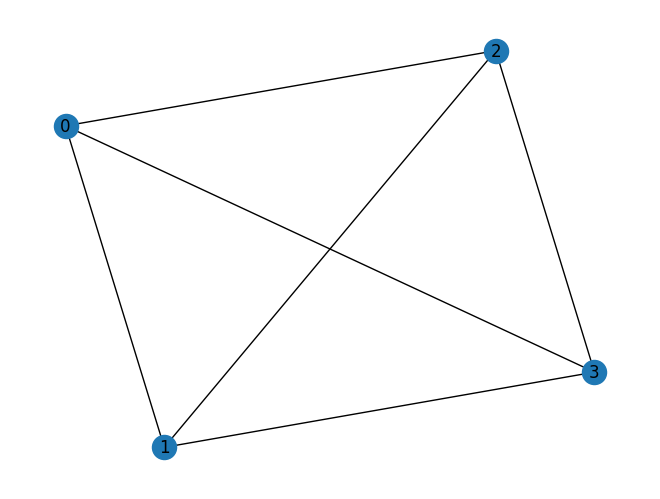

In [2]:
ideal_qc = get_qc('4q-qvm', noisy=False)
noisy_qc = get_qc("4q-noisy-qvm", noisy=True)

qubits = ideal_qc.qubits()
print('The qubits we will run on are', qubits)
graph = ideal_qc.qubit_topology()
nx.draw(graph, with_labels=True)

## Measure the quantum volume

Here we will replicate Figure 2. of [QVOL0].


### Start with the noiseless QVM

Caution, this is SLOW--it takes about 4 minutes.

In [3]:
from forest.benchmarking.quantum_volume import measure_quantum_volume

In [4]:
ideal_outcomes = measure_quantum_volume(ideal_qc, num_circuits=200, show_progress_bar=show_progress_bar)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [05:12<00:00,  1.56s/it]


### Now use a noisy QVM

This is SLOW--it takes about 5 minutes, even with half the number of shots from above.

In [5]:
noisy_outcomes = measure_quantum_volume(noisy_qc, num_circuits=200, num_shots=500, show_progress_bar=show_progress_bar)

100%|██████████| 200/200 [06:13<00:00,  1.87s/it]


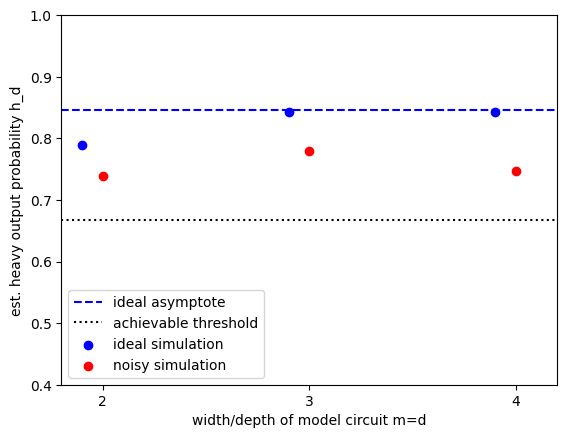

In [6]:
depths = np.arange(2, 5)
ideal_probs = [ideal_outcomes[depth][0] if depth in ideal_outcomes.keys() else 0 for depth in depths]
noisy_probs = [noisy_outcomes[depth][0] if depth in noisy_outcomes.keys() else 0 for depth in depths]

plt.axhline(.5 + np.log(2)/2, color='b', ls='--', label='ideal asymptote')
plt.axhline(2/3, color='black', ls=':', label='achievable threshold')
plt.scatter(np.array(depths) - .1, ideal_probs, color='b', label='ideal simulation')
plt.scatter(depths, noisy_probs, color='r', label='noisy simulation')
plt.ylabel("est. heavy output probability h_d")
plt.xlabel("width/depth of model circuit m=d")
plt.ylim(.4,1.0)
plt.xlim(1.8, 4.2)
plt.xticks(depths)
plt.legend(loc='lower left')
plt.show()

### Use a QVM with different topologies

As explained in the references [QVOL0, QVOL1, QVOL2] the quantum volume is topology (or qubit connectivity) dependent. Here we show how to explore that dependence on the QVM.

In [7]:
n = 4
path_graph = nx.path_graph(n)
loop_graph = nx.cycle_graph(n)
four_pointed_star = nx.star_graph(n)

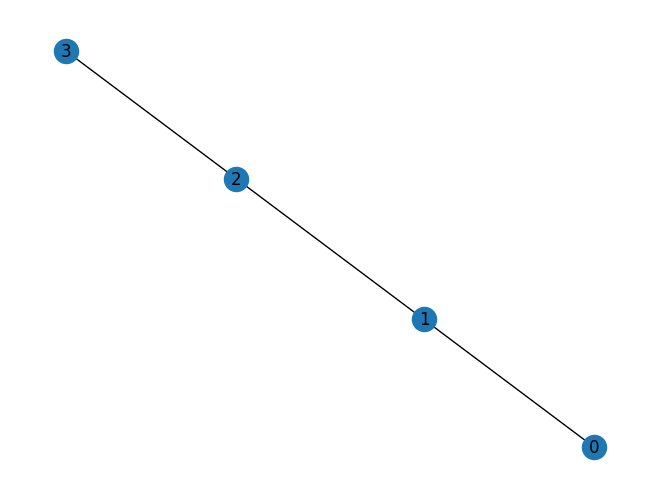

In [8]:
nx.draw(path_graph, with_labels=True)

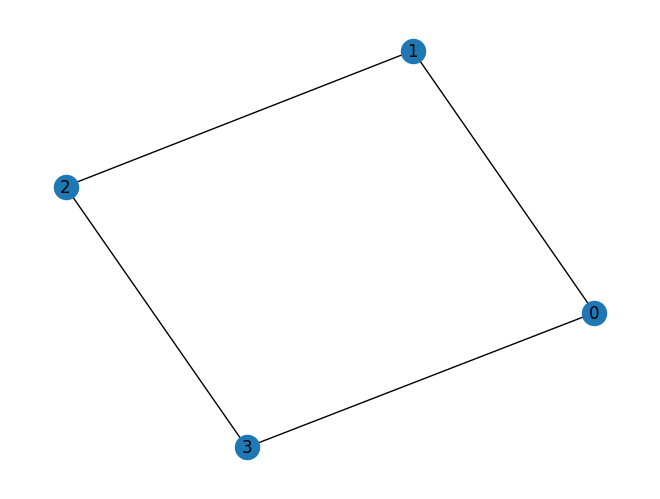

In [9]:
nx.draw(loop_graph, with_labels=True)

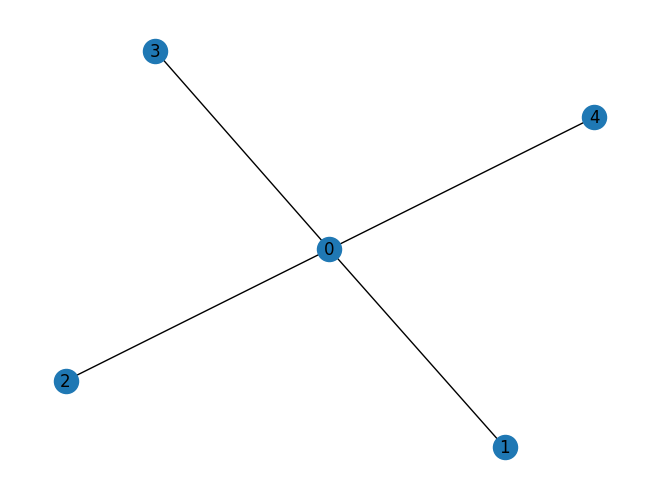

In [10]:
nx.draw(four_pointed_star, with_labels=True)

In [11]:
from pyquil.api._quantum_computer import _get_qvm_with_topology
from pyquil.api import QCSClient

path_qc = _get_qvm_with_topology(
    name='path',
    topology=path_graph,
    noisy=True,
    client_configuration=QCSClient.load(),
    qvm_type="qvm",
    compiler_timeout=10.0,
    execution_timeout=10.0,
)

In [12]:
path_outcomes = measure_quantum_volume(path_qc, num_circuits=200, num_shots=500, show_progress_bar=show_progress_bar)

100%|██████████| 200/200 [06:53<00:00,  2.07s/it]


### Compare to noisy complete topology

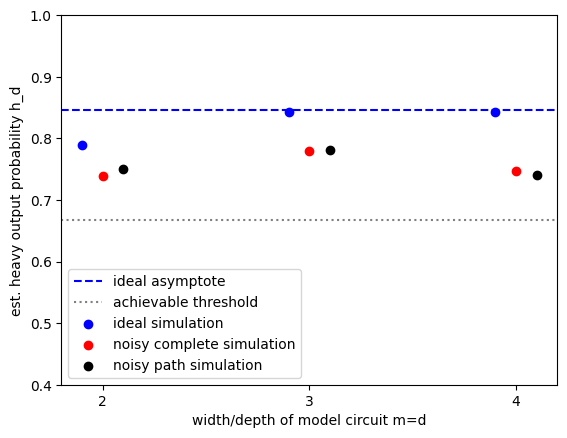

In [13]:
depths = np.arange(2, 5)
ideal_probs = [ideal_outcomes[depth][0] if depth in ideal_outcomes.keys() else 0 for depth in depths]
noisy_probs = [noisy_outcomes[depth][0] if depth in noisy_outcomes.keys() else 0 for depth in depths]
path_probs = [path_outcomes[depth][0] if depth in path_outcomes.keys() else 0 for depth in depths]

plt.axhline(.5 + np.log(2)/2, color='b', ls='--', label='ideal asymptote')
plt.axhline(2/3, color='grey', ls=':', label='achievable threshold')
plt.scatter(np.asarray(depths) - .1, ideal_probs, color='b', label='ideal simulation')
plt.scatter(depths, noisy_probs, color='r', label='noisy complete simulation')
plt.scatter(np.asarray(depths) + .1, path_probs, color='black', label='noisy path simulation')
plt.ylabel("est. heavy output probability h_d")
plt.xlabel("width/depth of model circuit m=d")
plt.ylim(.4,1.0)
plt.xlim(1.8, 4.2)
plt.xticks(depths)
plt.legend(loc='lower left')
plt.show()

## Run intermediate steps yourself

In [14]:
from pyquil import Program
from forest.benchmarking.quantum_volume import generate_abstract_qv_circuit, _naive_program_generator, collect_heavy_outputs
from pyquil.simulation import NumpyWavefunctionSimulator
from pyquil.gates import RESET
import time

def generate_circuits(depths):
    for d in depths:
        yield generate_abstract_qv_circuit(d)

def convert_ckts_to_programs(qc, circuits, qubits=None):
    for idx, ckt in enumerate(circuits):
        if qubits is None:
            d_qubits = qc.qubits()  # by default the program can act on any qubit in the computer
        else:
            d_qubits = qubits[idx]

        yield _naive_program_generator(qc, d_qubits, *ckt)


def acquire_quantum_volume_data(qc, programs, num_shots = 1000, use_active_reset = False):
    for program in programs:
        start = time.time()

        if use_active_reset:
            reset_measure_program = Program(RESET())
            program = reset_measure_program + program

        # run the program num_shots many times
        program.wrap_in_numshots_loop(num_shots)
        executable = qc.compiler.native_quil_to_executable(program)

        results = qc.run(executable).get_register_map().get('ro')

        runtime = time.time() - start
        yield results


def acquire_heavy_hitters(abstract_circuits):
    for ckt in abstract_circuits:
        perms, gates = ckt
        depth = len(perms)
        wfn_sim = NumpyWavefunctionSimulator(depth)

        start = time.time()
        heavy_outputs = collect_heavy_outputs(wfn_sim, perms, gates)
        runtime = time.time() - start

        yield heavy_outputs


Generate (len(unique_depths) x n_circuits) many "Abstract Ckt"s that describe each model circuit for each depth.

In [15]:
n_circuits = 100
unique_depths = [2,3]
depths = [d for d in unique_depths for _ in range(n_circuits)]
ckts = list(generate_circuits(depths))
print(ckts[0])

([array([1, 0]), array([0, 1])], array([[[[-0.15958965-0.27801567j,  0.65868291-0.12626327j,
           0.41033906+0.06983825j, -0.17647158-0.4929859j ],
         [-0.11207932-0.6027286j ,  0.03339941-0.41911816j,
           0.06608139+0.24414457j,  0.39605206+0.47597307j],
         [-0.65900703+0.10005676j,  0.16836876+0.19164729j,
          -0.39222017+0.47512715j, -0.28350631+0.17510959j],
         [-0.27010749+0.06430571j,  0.41121043+0.37315965j,
           0.10100064-0.61072707j,  0.24092286+0.41633168j]]],


       [[[-0.40241933+0.17656512j, -0.27194766-0.27997386j,
          -0.68934168-0.14930617j, -0.39557643-0.02403267j],
         [ 0.35537302-0.06921163j,  0.39018162-0.62700161j,
          -0.22683408+0.4538457j ,  0.02266444-0.2561323j ],
         [ 0.01606002+0.05296434j,  0.0727093 +0.43595067j,
           0.07930365+0.21453535j, -0.528766  -0.68533879j],
         [-0.67386314+0.46759869j,  0.24453271-0.2171417j ,
           0.37893721+0.22176161j,  0.14107058-0.0874107

Use the _naive_program_generator to synthesize native pyquil programs that implement each ckt natively on the qc.

In [16]:
progs = list(convert_ckts_to_programs(noisy_qc, ckts))
print(progs[0])

DECLARE ro BIT[2]
PRAGMA INITIAL_REWIRING "PARTIAL"
RZ(3.1052917986061024) 1
RX(pi/2) 1
RZ(1.0808532447914132) 1
RX(-pi/2) 1
RZ(1.9020628524661438) 1
RZ(2.466451840008778) 2
RX(pi/2) 2
RZ(2.6586008935485976) 2
RX(-pi/2) 2
RZ(-3.3541687732670105) 2
XY(pi) 1 2
RX(pi/2) 1
RZ(0.2072255135931852) 1
RX(-pi/2) 1
RZ((3*pi)/2) 1
RZ(-pi/2) 2
RX(pi/2) 2
RZ(pi/2) 2
RX(-pi/2) 2
RZ(2.6755077798664773) 2
XY(pi) 1 2
RX(pi/2) 1
RZ(pi/2) 1
RX(-pi/2) 1
RX(pi/2) 2
RZ(0.7961008461057862) 2
RX(-pi/2) 2
XY(pi) 1 2
RZ(-2.131656875438901) 1
RX(pi/2) 1
RZ(2.828409552188922) 1
RX(-pi/2) 1
RZ(1.4447361880543717) 1
RZ(1.6553574520131753) 2
RX(pi/2) 2
RZ(1.6842436740161737) 2
RX(-pi/2) 2
RZ(-2.723622872236606) 2
MEASURE 2 ro[1]
MEASURE 1 ro[0]



Run the programs. This can be slow.

In [17]:
num_shots=10
results = list(acquire_quantum_volume_data(noisy_qc, progs, num_shots=num_shots))

Classically simulate the circuits to get heavy hitters, and record how many hh were sampled for each program run.

In [18]:
ckt_hhs = acquire_heavy_hitters(ckts)

Count the number of heavy hitters that were sampled on the qc

In [19]:
from forest.benchmarking.quantum_volume import count_heavy_hitters_sampled
num_hh_sampled = count_heavy_hitters_sampled(results, ckt_hhs)

Get estimates of the probability of sampling hh at each depth, and the lower bound on that estimate

In [20]:
from forest.benchmarking.quantum_volume import get_prob_sample_heavy_by_depth

results = get_prob_sample_heavy_by_depth(depths, num_hh_sampled, [num_shots for _ in depths])
results

{2: (0.731, 0.6423120075771246), 3: (0.803, 0.7234535355908259)}

Use the results to get a lower bound on the quantum volume

In [21]:
from forest.benchmarking.quantum_volume import extract_quantum_volume_from_results
qv = extract_quantum_volume_from_results(results)
qv

2